In [30]:
import matplotlib.pyplot as plt
from yaml import load, Loader
import pandas as pd
from util.classes import PRIMARY_DEMOGRAPHICS
import re
from util.analysis_utils import plot_age_dist, plot_sex_dist, get_results, get_group_results, get_patients_info, merge_result_info
from util.dataset_utils import control_sex, control_age, control_ethnicity
import seaborn as sns


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Results

In [ ]:
patients_df = get_patients_info()

Number of Patients: 962
Total number of slices: 20802
---
DICE Mean:  92.19416931678802
RV Mean:  90.82333434435515
MYO Mean:  90.84940759295668
LV Mean:  94.90976601305228
---
Number of slices with DICE < 50.0%: 566


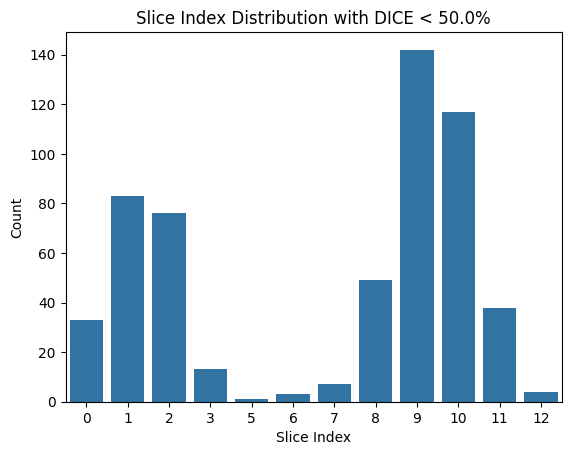

In [31]:
cfg = load(open('configs/ukbb_test_sex.yaml', 'r'), Loader=Loader)
test_sex_df = pd.read_csv(cfg['results_path'])
test_sex_merged_df = merge_result_info(test_sex_df, patients_df)
get_results(test_sex_merged_df)

In [28]:
get_group_results(test_sex_merged_df)

Dice Mean for Male: 92.19093783747923
Dice Mean for Female: 92.19760528764603
Mean Dice for White:
   ethnicity  dice_mean
0     1001.0  92.387895
1     1002.0  93.030053
2     1003.0  91.992282
Mean: 92.38789520166718
Mean Dice for Asian:
   ethnicity  dice_mean
0     3001.0  91.027562
1     3002.0  91.540833
2     3004.0  92.589511
Mean: 91.02756206061161
Mean Dice for Black:
   ethnicity  dice_mean
0     4001.0  91.068725
1     4002.0  91.075574
2     4003.0  90.802458
Mean: 91.06872545963455


Most slices with low scores are either near the apex or the base where the segmentation ground truth is not meaningful for the task.

Number of Patients: 108
Total number of slices: 2300
---
DICE Mean:  91.10602820319252
RV Mean:  89.61749375248424
MYO Mean:  89.55695180507983
LV Mean:  94.14363905201354
---
Number of slices with DICE < 50.0%: 84


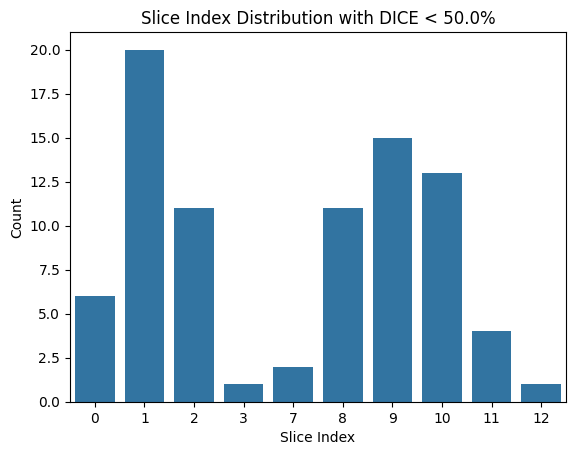

In [35]:
cfg = load(open('configs/ukbb_test_ethn.yaml', 'r'), Loader=Loader)
test_ethn_df = pd.read_csv(cfg['results_path'])
test_ethn_merged_df = merge_result_info(test_ethn_df, patients_df)
get_results(test_ethn_merged_df)

In [36]:
get_group_results(test_ethn_merged_df)

Dice Mean for Male: 91.55549523265698
Dice Mean for Female: 90.63902877186955
Mean Dice for White:
   ethnicity  dice_mean
0     1001.0  90.748787
1     1003.0  93.223375
Mean: 90.7487866002082
Mean Dice for Asian:
   ethnicity  dice_mean
0     3001.0  90.342943
1     3002.0  92.628563
2     3003.0  93.353328
3     3004.0  92.298133
Mean: 90.34294284146524
Mean Dice for Black:
   ethnicity  dice_mean
0     4001.0  90.774393
1     4002.0  92.641555
2     4003.0  90.802458
Mean: 90.77439278802615


# UKBB Dataset

### Data Tidying
- extract certain cols
- change col name instead of codes
- get patients with SA images

In [5]:
sa_df_eids = pd.read_csv('splits/ukbb/all.csv')
merged_df = pd.merge(df, sa_df_eids, on='eid')
len(merged_df)

46836

## Baseline Dataset

### Train on 5k

- White 4k
- Asian 506
- Black 313

### Split:

- Train 70%
- Validation 10%
- Test 20% (control for age, sex, ethnicity)

In [81]:
all_wht_df = merged_df[merged_df['ethnicity'].astype(str).str.startswith('1')]
print('White', len(all_wht_df))

all_as_df = merged_df[merged_df['ethnicity'].astype(str).str.startswith('3')]
print('Asian', len(all_as_df))

all_bl_df = merged_df[merged_df['ethnicity'].astype(str).str.startswith('4')]
print('Black', len(all_bl_df))

White 45296
Asian 506
Black 313


Mean age for White: 55.16025
STD age for White: 7.5186237013891555
Mean age for Asian: 52.258893280632414
STD age for Asian: 8.185363051062385
Mean age for Black: 50.01277955271566
STD age for Black: 6.936975640102496


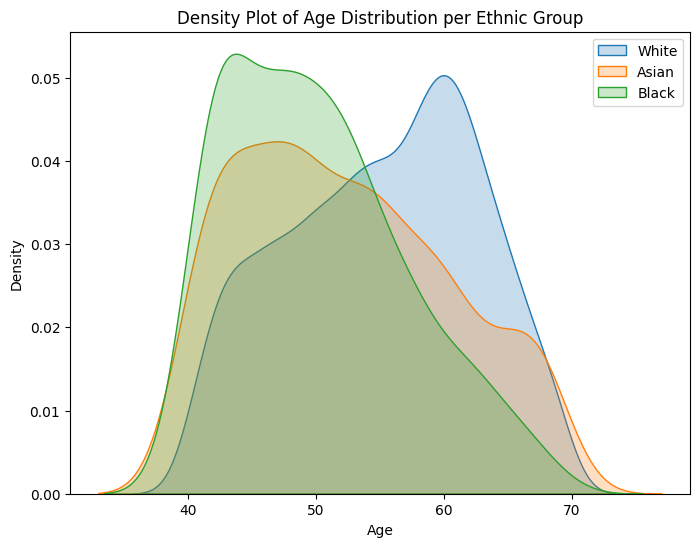

Coding 1 means White and has 4000 patients, male 1911, female 2089
Coding 3 means Asian and has 506 patients, male 322, female 184
Coding 4 means Black and has 313 patients, male 141, female 172


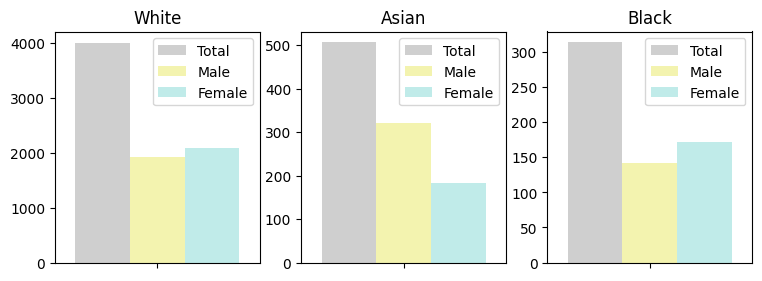

In [62]:
sample_wht_df = all_wht_df.sample(n=4000, random_state=42)
dataset_df = pd.concat([sample_wht_df, all_as_df, all_bl_df])
plot_age_dist(dataset_df)
plot_sex_dist(dataset_df)

# Testset

## Controlled for Age
Split: 20%

Mean age for White: 51.417396061269145
STD age for White: 3.683163873183258
Mean age for Asian: 50.703125
STD age for Asian: 3.6576203021240197
Mean age for Black: 50.46448087431694
STD age for Black: 3.615837511607302


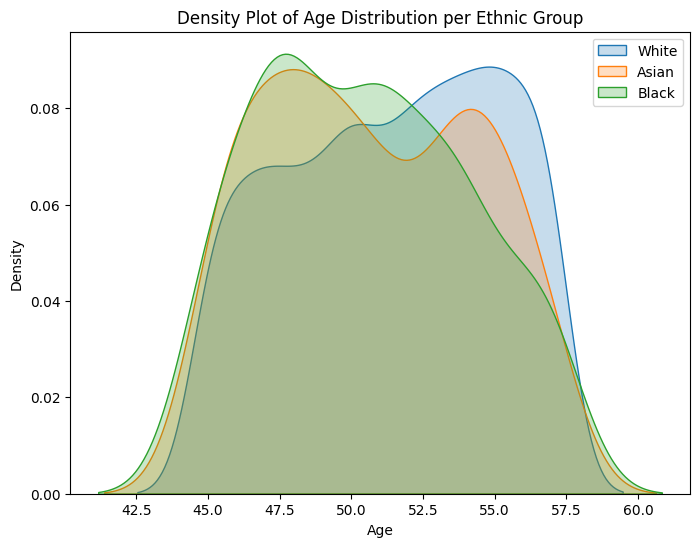

Coding 1 means White and has 1828 patients, male 805, female 1023
Coding 3 means Asian and has 256 patients, male 164, female 92
Coding 4 means Black and has 183 patients, male 79, female 104


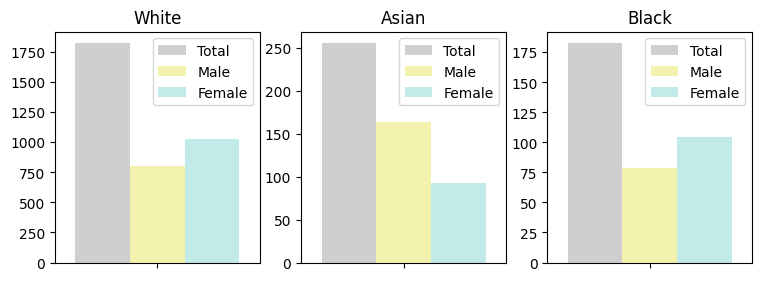

In [98]:
split_prcnts = {
    'train': 0.8,
    'val': 0.1,
    'test': 0.2
}

wht_test_age_ctrl_df = control_age(sample_wht_df)
as_test_age_ctrl_df = control_age(all_as_df)
bl_test_age_ctrl_df = control_age(all_bl_df)
test_age_ctrl_df = pd.concat([wht_test_age_ctrl_df, as_test_age_ctrl_df, bl_test_age_ctrl_df])
plot_age_dist(test_age_ctrl_df)
plot_sex_dist(test_age_ctrl_df)

## Contolled for Sex

Mean age for White: 51.39625
STD age for White: 3.5917073084031426
Mean age for Asian: 50.89
STD age for Asian: 3.7251398184050313
Mean age for Black: 50.435483870967744
STD age for Black: 3.7136035600713946


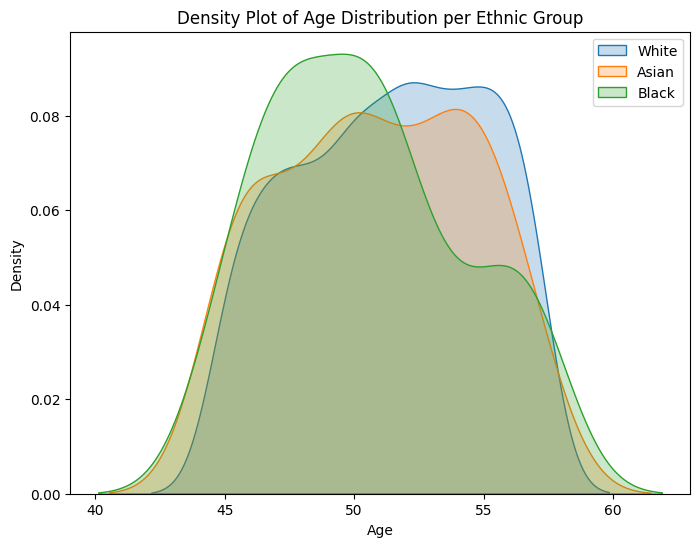

Coding 1 means White and has 800 patients, male 400, female 400
Coding 3 means Asian and has 100 patients, male 50, female 50
Coding 4 means Black and has 62 patients, male 31, female 31


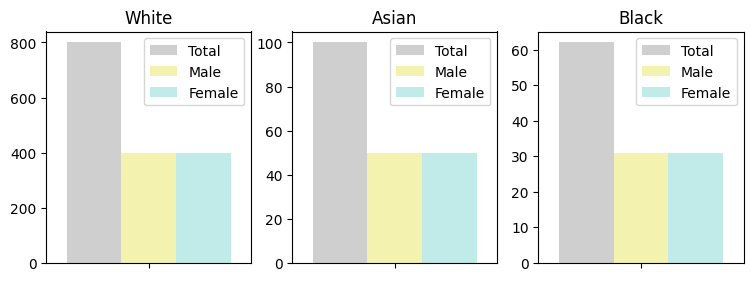

In [99]:
wht_test_sex_ctrl_df = control_sex(wht_test_age_ctrl_df, split_prcnts['test'], len(sample_wht_df))
as_test_sex_ctrl_df = control_sex(as_test_age_ctrl_df, split_prcnts['test'], len(all_as_df))
bl_test_sex_ctrl_df = control_sex(bl_test_age_ctrl_df, split_prcnts['test'], len(all_bl_df))
test_sex_ctrl_df = pd.concat([wht_test_sex_ctrl_df, as_test_sex_ctrl_df, bl_test_sex_ctrl_df])
plot_age_dist(test_sex_ctrl_df)
plot_sex_dist(test_sex_ctrl_df)
test_sex_ctrl_df.to_csv('ukbb/test_sex_ctrl.csv', index=False)

## Controlled for Ethnicity

Mean age for White: 50.416666666666664
STD age for White: 3.752142245247564
Mean age for Asian: 50.611111111111114
STD age for Asian: 3.6744506122122935
Mean age for Black: 50.888888888888886
STD age for Black: 3.4207582933594276


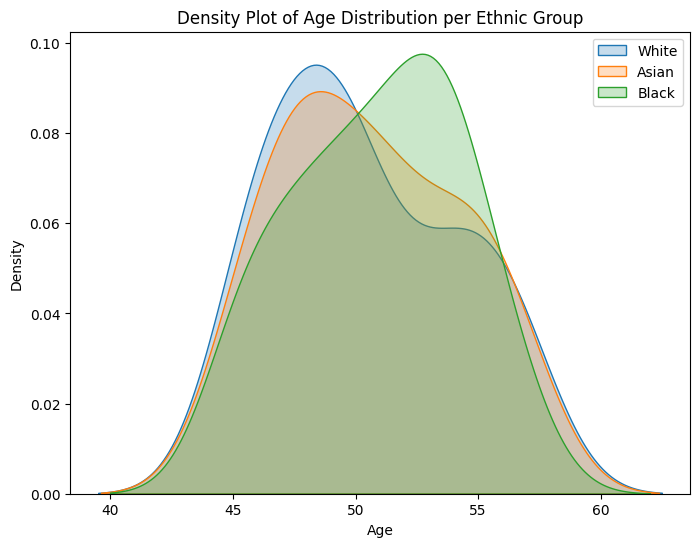

Coding 1 means White and has 36 patients, male 16, female 20
Coding 3 means Asian and has 36 patients, male 19, female 17
Coding 4 means Black and has 36 patients, male 17, female 19


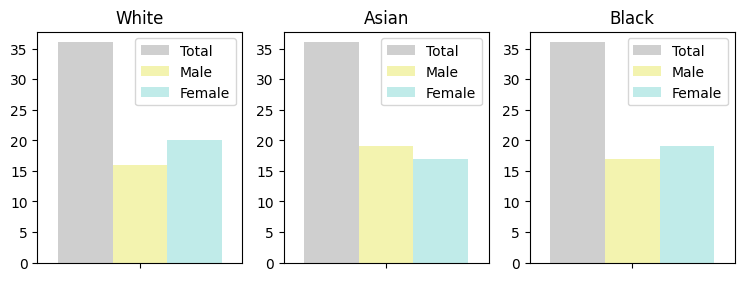

In [105]:
from util.dataset_utils import control_ethnicity
whtn = len(wht_test_age_ctrl_df) * split_prcnts['test']
asn = len(as_test_age_ctrl_df) * split_prcnts['test']
bln = len(bl_test_age_ctrl_df) * split_prcnts['test']
n = int(min(whtn, asn, bln))
test_ethn_ctrl_df = control_ethnicity(test_age_ctrl_df, n)
plot_age_dist(test_ethn_ctrl_df)
plot_sex_dist(test_ethn_ctrl_df)
test_ethn_ctrl_df.to_csv('ukbb/test_ethn_ctrl.csv', index=False)

# Train, Validation Sets

In [ ]:
whole_test_df = pd.concat([test_sex_ctrl_df, test_ethn_ctrl_df])
train_val_df = dataset_df.drop(whole_test_df.index)
val_df = train_val_df.sample(frac=0.13, random_state=42)
train_df = train_val_df.drop(val_df.index)

In [112]:
print(f'Train: {len(train_df)} subjects, {len(train_df)/len(dataset_df)*100.0:.2f}%')
print(f'Validation: {len(val_df)} subjects, {len(val_df)/len(dataset_df)*100.0:.2f}%')
print(f'Whole Test: {len(whole_test_df)} subjects, {len(whole_test_df)/len(dataset_df)*100.0:.2f}%')
print(f'Test Sex Controlled: {len(test_sex_ctrl_df)} subjects, {len(test_sex_ctrl_df)/len(dataset_df)*100.0:.2f}%')
print(f'Test Ethnicity Controlled: {len(test_ethn_ctrl_df)} subjects, {len(test_ethn_ctrl_df)/len(dataset_df)*100.0:.2f}%')

Train: 3301 subjects, 68.50%
Validation: 493 subjects, 10.23%
Whole Test: 1070 subjects, 22.20%
Test Sex Controlled: 962 subjects, 19.96%
Test Ethnicity Controlled: 108 subjects, 2.24%


In [96]:
train_df.to_csv('ukbb/train.csv', index=False)
val_df.to_csv('ukbb/val.csv', index=False)
test_sex_ctrl_df.to_csv('ukbb/test_sex_ctrl.csv', index=False)
test_ethn_ctrl_df.to_csv('ukbb/test_ethn_ctrl.csv', index=False)

# Training on 330
took 2-19:08:29 for 57 epochs

best: 94.94

# Testing
2 Datasets on model 5k

train on unbalanced 350 for 150 epochs

train on balanced sets 350
- sex
- ethinicity



## Labeled vs Unlabeled
1%, 5%, 10% check label choice effect on the results

## Merge Asian, Chinese